In [7]:
# import library
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd

In [8]:
# load dataset
iris = load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

X = df.drop(columns=['target'])
y = df['target']

# split data biar lebih realistik
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

In [9]:
# Definisikan Fungsi Bayesian Optimization

# Fungsi yang mengembalikan skor cross-validation
def rf_cv(n_estimators, max_depth):
    model = RandomForestClassifier(
        random_state=42,
        n_estimators=int(n_estimators), # Harus integer
        max_depth=int(max_depth),
    )
    return np.mean(cross_val_score(model, X_train, y_train)) # skor rata2

In [10]:
# optimasi dengan Bayesian Optimization

# Inisialisasi optimizer
pbounds = {
    'n_estimators': (10, 200),
    'max_depth': (2, 10)
}

optimizer = BayesianOptimization(f=rf_cv, pbounds=pbounds, random_state=42)

# jalankan optimasi
optimizer.maximize(init_points=3, n_iter=10)

# tampilkan hasil terbaik
print('Hasil Terbaik: ',optimizer.max)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.95      | 4.996     | 190.6     |
| 2         | 0.9417    | 7.856     | 123.7     |
| 3         | 0.9417    | 3.248     | 39.64     |
| 4         | 0.95      | 4.239     | 191.4     |
| 5         | 0.95      | 9.89      | 200.0     |
| 6         | 0.9417    | 2.004     | 175.2     |
| 7         | 0.9417    | 9.721     | 81.67     |
| 8         | 0.95      | 9.785     | 10.38     |
| 9         | 0.9333    | 2.028     | 16.2      |
| 10        | 0.95      | 9.842     | 193.6     |
| 11        | 0.9417    | 2.24      | 199.8     |
| 12        | 0.9417    | 9.953     | 184.9     |
| 13        | 0.95      | 9.987     | 150.5     |
Hasil Terbaik:  {'target': 0.95, 'params': {'max_depth': 4.9963209507789, 'n_estimators': 190.63571821788406}}


In [15]:
# Coba model dengan hasil terbaik
best_params = optimizer.max['params']

rf_best = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=15,  # Coba minimal 5 sample buat split
    min_samples_leaf=6,    # Coba minimal 2 leaf nodes
    random_state=42
)


rf_best.fit(X_train, y_train)
print('Akurasi di test set: ', rf_best.score(X_test, y_test))

Akurasi di test set:  1.0


## 🚀 Kesimpulan
#### Kita pakai Bayesian Optimization buat cari hyperparameter terbaik.
#### Lebih efisien dibanding Grid Search atau Random Search.
#### Cen bisa coba eksperimen dengan model lain kayak XGBoost atau LightGBM!

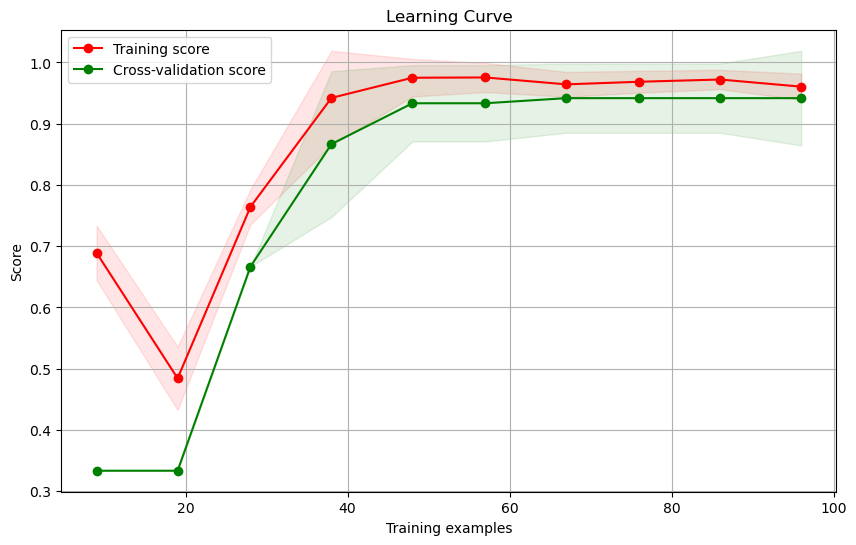

In [16]:
# learning curve berdasarkan training model

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_best, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Prediksi di test set
y_pred = rf_best.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred, target_names=iris.target_names)
print("\nClassification Report:")
print(cr)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy Score:", accuracy)

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Accuracy Score: 1.0


In [18]:
from sklearn.model_selection import cross_val_score

# Lakukan cross-validation
cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='accuracy')

# Tampilkan hasil cross-validation
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.95833333 1.         0.79166667 1.         0.95833333]
Mean cross-validation score: 0.9416666666666667
